In [5]:
# Imports
import numpy as np
import matplotlib.pylab as plt
from zipfile import ZipFile

import sklearn.datasets
from sklearn.model_selection import train_test_split
import sklearn.metrics
import sklearn.model_selection
from sklearn.svm import SVC

from collections import Counter
import random

from string import punctuation
import spacy

nlp = spacy.load("en_core_web_lg")

In [6]:
# Loading data
zpath = "English.zip" 
with ZipFile(zpath) as zipObj:
    zipObj.extractall()

ENpath = "English" 
data = sklearn.datasets.load_files(ENpath, encoding="utf-8")

# Fields:
# data, filenames, target_names, target, DESCR
print("Filenames:\n\t", data['filenames'])
print("Target names:\n\t", data['target_names'])
print("Targets:\n\t", data['target'])

Filenames:
	 ['English\\Caroll\\Feeding the Mind EN.txt'
 'English\\Dostroevsky\\Crime and Punishment EN.txt'
 'English\\Dostroevsky\\The Eternal Husband EN.txt'
 'English\\Doyle\\A Scandal in Bohemia EN.txt'
 'English\\Souseki\\Kokoro EN.txt' 'English\\Dazai\\Pandoras Box EN.txt'
 'English\\Caroll\\What the Tortoise Said to Achilles EN.txt'
 'English\\Souseki\\I am a Cat EN.txt'
 'English\\Doyle\\The Adventure of the Dancing Men EN.txt'
 'English\\Dostroevsky\\The Brothers Karamazov EN.txt'
 'English\\Doyle\\The Red-Headed League EN.txt'
 'English\\Dazai\\No Longer Human EN.txt'
 'English\\Caroll\\Alice in Wonderland EN.txt'
 'English\\Dazai\\The Setting Sun EN.txt'
 'English\\Souseki\\Botchan EN.txt']
Target names:
	 ['Caroll', 'Dazai', 'Dostroevsky', 'Doyle', 'Souseki']
Targets:
	 [0 2 2 3 4 1 0 4 3 2 3 1 0 1 4]


In [7]:
%%time

# Manually increase length to be able to tokenize
nlp.max_length = 2000000 

# Preprocessing
tokenized = []

for i, text in enumerate(data['data']):
    print("Tokenizing... " + str(i) + "/" + str(len(data['filenames'])))
    print("Current file:", data['filenames'][i])
    doc = nlp(text)
    tokenized.append(doc)

Tokenizing... 0/15
Current file: English\Caroll\Feeding the Mind EN.txt
Tokenizing... 1/15
Current file: English\Dostroevsky\Crime and Punishment EN.txt
Tokenizing... 2/15
Current file: English\Dostroevsky\The Eternal Husband EN.txt
Tokenizing... 3/15
Current file: English\Doyle\A Scandal in Bohemia EN.txt
Tokenizing... 4/15
Current file: English\Souseki\Kokoro EN.txt
Tokenizing... 5/15
Current file: English\Dazai\Pandoras Box EN.txt
Tokenizing... 6/15
Current file: English\Caroll\What the Tortoise Said to Achilles EN.txt
Tokenizing... 7/15
Current file: English\Souseki\I am a Cat EN.txt
Tokenizing... 8/15
Current file: English\Doyle\The Adventure of the Dancing Men EN.txt
Tokenizing... 9/15
Current file: English\Dostroevsky\The Brothers Karamazov EN.txt
Tokenizing... 10/15
Current file: English\Doyle\The Red-Headed League EN.txt
Tokenizing... 11/15
Current file: English\Dazai\No Longer Human EN.txt
Tokenizing... 12/15
Current file: English\Caroll\Alice in Wonderland EN.txt
Tokenizing.

In [8]:
# First check the total TOKEN length per author
print("Amount of extracted tokens per author:")

per_token = []
for x in tokenized:
    per_token.append([token for token in doc])

for i in range(max(data['target'])+1):
    indices = np.where(data['target'] == i)

    print(data['target_names'][i], ":", sum([len(per_token[i]) for i in np.array(indices)[0]]))
print()

# Check total character lenght per author
print("Amount of characters per author:")

for i in range(max(data['target'])+1):
    indices = np.where(data['target'] == i)
    
    print(data['target_names'][i], ":", sum([len(data['data'][i]) for i in np.array(indices)[0]]))

Amount of extracted tokens per author:
Caroll : 194259
Dazai : 194259
Dostroevsky : 194259
Doyle : 194259
Souseki : 194259

Amount of characters per author:
Caroll : 161360
Dazai : 579153
Dostroevsky : 2469119
Doyle : 149351
Souseki : 1804656


In [9]:
%%time

# Check common words, and how common names are

i = 0

surface = [x.text for x in tokenized[i]]
counts = {item:text.count(item) for item in surface}
x = Counter(counts)
for c in x.most_common(25):
    print(c)
print()

('a', 18535)
('he', 5621)
('in', 4135)
('the', 3518)
(',', 3207)
('an', 3086)
('.', 3041)
('to', 2492)
('as', 2340)
('at', 2302)
('I', 2182)
('on', 2152)
('it', 2043)
('me', 1857)
('or', 1769)
('is', 1646)
('and', 1370)
('"', 1354)
('of', 1342)
('be', 1338)
('no', 1213)
('\n', 1184)
('was', 988)
('we', 804)
('so', 760)

CPU times: total: 1.12 s
Wall time: 1.13 s


In [10]:
# Split into smaller parts, update the target list to reflect that
target = []
data_split = []

string_cut = ""
n = 5

# Make cuts of 5 sentences per new part
for i, t in enumerate(data['target']):
    
    for sentence in [sent.text for sent in tokenized[i].sents]:
        string_cut += sentence
        n-=1
        
        if n<0:
            data_split.append(string_cut)
            target.append(t)
            n = 5
            string_cut = ""

In [11]:
# Make an equal selection of parts so all authors are equally represented

print("Before equalizing authors:")
author_count = {data['target_names'][item]:target.count(item) for item in target}
print(author_count)

i_rand = []

# Get a random sample of the size of the author with the least parts
for t in range(max(data['target'])+1):
    
    target_indices = list(np.where(target == np.int32(t))[0])
    random_sample = random.sample(target_indices, k = min(author_count.values())) 
    i_rand.append(random_sample)
    
i_rand = [item for sublist in i_rand for item in sublist] # -> flatten

# This is the final data we're working with
data_cut = [data_split[i] for i in i_rand]  
target_cut = [target[i] for i in i_rand]         

print()
print("After equalizing authors:")
author_count = {data['target_names'][item]:target_cut.count(item) for item in target_cut}
print(author_count)

Before equalizing authors:
{'Caroll': 326, 'Dostroevsky': 5478, 'Doyle': 303, 'Souseki': 3762, 'Dazai': 1417}

After equalizing authors:
{'Caroll': 303, 'Dazai': 303, 'Dostroevsky': 303, 'Doyle': 303, 'Souseki': 303}


In [12]:
# Train test set generation
X_train, X_test, y_train, y_test = train_test_split(data_cut, target_cut, test_size=0.2, random_state=1)

In [13]:
def contains_character(token, characters):
    token = token.lower()
    for char in token:
        if char in characters:
            return True
    return False

In [14]:
# Extract features from a given text
def extract_features(text, leave_out=0):
    '''
    text: The text we want to extract features from
    plot: Which features we want to leave out:
        0: None
        1: Lexical features
        2: Character features
        3: POS tags
        4: Function words
    '''
    
    function_words = ["a", "between", "in", "nor", "some", "upon", "about", "both", "including",
                      "nothing", "somebody", "us", "above", "but", "inside", "of", "someone", "used", 
                      "after", "by", "into", "off", "something", "via", "all", "can", "is", "on", 
                      "such", "we", "although", "cos", "it", "once", "than", "what", "am", "do", 
                      "its", "one", "that", "whatever", "among", "down", "latter", "onto", "the", 
                      "when", "an", "each", "less", "opposite", "their", "where", "and", "either",
                      "like", "or", "them", "whether", "another", "enough", "little", "our", "these", 
                      "which", "any", "every", "lots", "outside", "they", "while", "anybody",
                      "everybody", "many", "over", "this", "who", "anyone", "everyone", "me", "own", 
                      "those", "whoever", "anything", "everything", "more", "past", "though", "whom", 
                      "are", "few", "most", "per", "through", "whose", "around", "following", "much", 
                      "plenty", "till", "will", "as", "for", "must", "plus", "to", "with", "at", "from", 
                      "my", "regarding", "toward", "within", "be", "have", "near", "same", "towards",
                      "without", "because", "he", "need", "several", "under", "worth", "before", "her", 
                      "neither", "she", "unless", "would", "behind", "him", "no", "should", "unlike",
                      "yes", "below", "i", "nobody", "since", "until", "you", "beside", "if", "none", 
                      "so", "up", "your"]
    pos_tags = ["ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT",
                "SCONJ","SYM","VERB","X"]
    stopwords = nlp.Defaults.stop_words


    # Apply model pipeline to text
    doc = nlp(text)

    bag_of_words = [token.text for token in doc]
    bag_of_sentences = [sent.text for sent in doc.sents]

    features = []
    
    
    # LEXICAL FEATURES
    if not leave_out == 1:

        # Count the number of words
        features.append(len(bag_of_words))

        # Count the number of words, excluded the stopwords
        features.append(len([token for token in bag_of_words if token.lower() not in stopwords]))

        # Total number of sentences
        features.append(len(bag_of_sentences))

        # Words without vowels
        features.append(len([token for token in bag_of_words if not contains_character(token, "aeiou")]))

        # Total contraction count
        features.append(len([token for token in bag_of_words if contains_character(token, "'")]))


    # CHARACTER FEATURES
    if not leave_out == 2:

        # Total number of characters
        features.append(len(text))

        # Total alphabet count
        features.append(len([character for token in bag_of_words for character in token if contains_character(character,"qwertyuiopasdfghjklzxcvbnm")]))

        # Total punctuation count
        features.append(len([character for token in bag_of_words for character in token if contains_character(character, punctuation)]))

        # Parenthesis count
        features.append(len([character for token in bag_of_words for character in token if contains_character(character, "()")]))

        # Quotation count
        features.append(len([character for token in bag_of_words for character in token if contains_character(character, '"')]))

        # Question frequency
        features.append(len([character for token in bag_of_words for character in token if contains_character(character, "?")]))

        # Frequency of letters
        for letter in [chr(i) for i in range(97,123)]: # For every letter in the alphabet

            # Count how many times that letter occurs
            letter_count = len([character for token in bag_of_words for character in token if contains_character(character, letter)])

            # Normalize that number by the total amount of non whitespace characters
            normalized = letter_count/len([character for token in bag_of_words for character in token])

            # Add that as a separate feature
            features.append(normalized)


    # POS TAGS
    if not leave_out == 3:

        # Parts of speech (POS) tags frequency
        for pos in pos_tags:
            features.append(len([token for token in doc if token.pos_ == pos]))


    # FUNCTION WORDS
    if not leave_out == 4:

        # Function words frequency
        for fword in function_words: # For every function word

            # Count how many times that word occurs
            fword_count = len([token for token in bag_of_words if token == fword])
            
            # Add that as a separate feature
            features.append(fword_count)

    return features

In [15]:
print("Amount of features extracted:", len(extract_features(X_train[0])))

print("Sample:")
print(extract_features(X_train[0]))

Amount of features extracted: 204
Sample:
[178, 85, 5, 28, 0, 857, 680, 21, 0, 0, 0, 0.0691114245416079, 0.015514809590973202, 0.0380818053596615, 0.028208744710860368, 0.10437235543018336, 0.018335684062059238, 0.018335684062059238, 0.06488011283497884, 0.08039492242595205, 0.0, 0.005641748942172073, 0.029619181946403384, 0.02679830747531735, 0.07193229901269393, 0.06629055007052186, 0.02538787023977433, 0.0028208744710860366, 0.0535966149506347, 0.07334273624823695, 0.08039492242595205, 0.031029619181946404, 0.011283497884344146, 0.01692524682651622, 0.004231311706629055, 0.022566995768688293, 0.0, 8, 21, 14, 6, 4, 13, 1, 27, 2, 3, 26, 1, 21, 8, 0, 22, 0, 2, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 5, 1, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 3, 2, 0, 0, 4, 0

In [16]:
# Classify using the features
def classify(train_features, train_labels, test_features):
    clf = SVC(kernel='linear')
    clf.fit(train_features, train_labels)
    return clf.predict(test_features)

In [17]:
# Evaluate predictions (y_pred) given the ground truth (y_true)
def evaluate(y_true, y_pred, verbose=True):
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='macro')
    # recall = sklearn.metrics.recall_score(y_true, y_pred, average='weighted')
    if verbose:
        print("Recall: %f" % recall)

    precision = sklearn.metrics.precision_score(y_true, y_pred, average='macro')
    # precision = sklearn.metrics.precision_score(y_true, y_pred, average='weighted')
    if verbose:
        print("Precision: %f" % precision)

    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    # f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    if verbose:
        print("F1-score: %f" % f1_score)

    return recall, precision, f1_score

In [21]:
# Classify and evaluate
def classify_and_evaluate(verbose=True, leave_out=0):

    # Extract the features
    print("Extracting features...")
    features = list(map(extract_features, X_train, [leave_out for x in range(len(X_train))]))
    print("Done!")

    print("Amount of features extracted:", len(features[0]))

    skf = sklearn.model_selection.StratifiedKFold(n_splits=5)
    scores = []
    for fold_id, (train_indexes, validation_indexes) in enumerate(skf.split(X_train, y_train)):
        # Print the fold number
        if verbose:
            print("Fold %d" % (fold_id + 1))

        # Collect the data for this train/validation split
        train_features = [features[x] for x in train_indexes]
        train_labels = [y_train[x] for x in train_indexes]

        validation_features = [features[x] for x in validation_indexes]
        validation_labels = [y_train[x] for x in validation_indexes]

        # Classify and add the scores to be able to average later
        y_pred = classify(train_features, train_labels, validation_features)

        scores.append(evaluate(validation_labels, y_pred, verbose))

        # Print a newline
        if verbose:
            print("")

    # Print the averaged score
    recall = sum([x[0] for x in scores]) / len(scores)
    if verbose:
        print("Averaged total recall", recall)
    precision = sum([x[1] for x in scores]) / len(scores)
    if verbose:
        print("Averaged total precision", precision)
    f_score = sum([x[2] for x in scores]) / len(scores)
    if verbose:
        print("Averaged total f-score", f_score)
        print("")

    test_features = list(map(extract_features, X_test, [leave_out for x in range(len(X_test))]))

    y_pred = classify(features, y_train, test_features)
    
    return evaluate(y_test, y_pred)

In [25]:
%%time

classify_and_evaluate(verbose=True, leave_out=0)

Extracting features...
Done!
Amount of features extracted: 204
Fold 1
Recall: 0.715000
Precision: 0.716203
F1-score: 0.711756

Fold 2
Recall: 0.679000
Precision: 0.676671
F1-score: 0.677181

Fold 3
Recall: 0.694333
Precision: 0.702101
F1-score: 0.696485

Fold 4
Recall: 0.663000
Precision: 0.666206
F1-score: 0.661962

Fold 5
Recall: 0.720333
Precision: 0.732701
F1-score: 0.722513

Fold 6
Recall: 0.730000
Precision: 0.737336
F1-score: 0.723932

Fold 7
Recall: 0.719406
Precision: 0.737454
F1-score: 0.721774

Fold 8
Recall: 0.761188
Precision: 0.767810
F1-score: 0.762832

Fold 9
Recall: 0.702333
Precision: 0.712194
F1-score: 0.703696

Fold 10
Recall: 0.746000
Precision: 0.737145
F1-score: 0.740044

Averaged total recall 0.7130594202898551
Averaged total precision 0.7185819609116109
Averaged total f-score 0.7122175268756974

Recall: 0.697340
Precision: 0.694542
F1-score: 0.694931
CPU times: total: 13min 42s
Wall time: 13min 43s


(0.6973397235586554, 0.6945416287736943, 0.6949314704208134)

In [22]:
%%time

# Leave out different feature groups
results = []
for i in range(5):
    results.append(classify_and_evaluate(verbose=True, leave_out=i)[2])

Extracting features...
Done!
Amount of features extracted: 204
Fold 1
Recall: 0.700779
Precision: 0.703807
F1-score: 0.701159

Fold 2
Recall: 0.666687
Precision: 0.667738
F1-score: 0.664910

Fold 3
Recall: 0.666190
Precision: 0.667132
F1-score: 0.666340

Fold 4
Recall: 0.657908
Precision: 0.660007
F1-score: 0.656926

Fold 5
Recall: 0.736480
Precision: 0.741867
F1-score: 0.734446

Averaged total recall 0.6856087277464178
Averaged total precision 0.6881101041956871
Averaged total f-score 0.6847562525088613

Recall: 0.687138
Precision: 0.690325
F1-score: 0.687786
Extracting features...
Done!
Amount of features extracted: 199
Fold 1
Recall: 0.613197
Precision: 0.613618
F1-score: 0.613279

Fold 2
Recall: 0.551685
Precision: 0.552771
F1-score: 0.549882

Fold 3
Recall: 0.591602
Precision: 0.597785
F1-score: 0.592218

Fold 4
Recall: 0.632993
Precision: 0.639493
F1-score: 0.628396

Fold 5
Recall: 0.624575
Precision: 0.636035
F1-score: 0.621781

Averaged total recall 0.6028104646113764
Averaged 

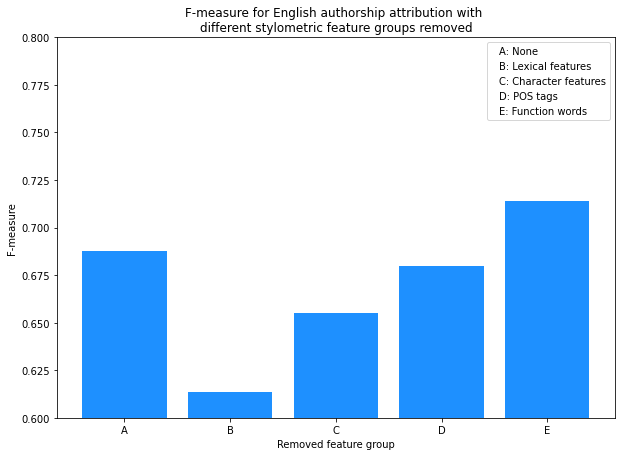

In [23]:
# Creating histogram
groups = ["A", "B", "C", "D", "E"]
labels = ["A: None", "B: Lexical features", "C: Character features", "D: POS tags", "E: Function words"]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(groups)):
    ax.bar(groups[i], results[i], label=labels[i], color='DodgerBlue')
plt.xlabel("Removed feature group")
plt.ylabel("F-measure")
plt.ylim((0.60, 0.80))
plt.legend(handlelength=0)
plt.title("F-measure for English authorship attribution with \ndifferent stylometric feature groups removed")

# Show plot
plt.show()